Classificação de nível de desgaste a partir das frequências de ressonância

In [2]:
!pip install git+https://github.com/eduardobatista/ActVibModules.git

  Cloning https://github.com/eduardobatista/ActVibModules.git to c:\users\jpsfb\appdata\local\temp\pip-req-build-lz__q90w
  Resolved https://github.com/eduardobatista/ActVibModules.git to commit 0d3d0b6a3212268aae594dab12c10e4c61ce2aa7
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached pyarrow-17.0.0-cp312-cp312-win_amd64.whl.metadata (3.4 kB)
Using cached pyarrow-17.0.0-cp312-cp312-win_amd64.whl (25.1 MB)
  Created wheel for ActVibModules: filename=actvibmodules-1.0-py2.py3-none-any.whl size=9136 sha256=520a0afdd6db183deb639a4768c23e1b1204b60510eab6bda8b3ca0c11cde6cc
  Stored in directory: C:\Users\jpsfb\AppData\Local\Temp\pip-ephem-wheel-cache-n5jumh99\wheels\6d\c1\1b\256b1ee64e67cc78af94f4f0192

  Running command git clone --filter=blob:none --quiet https://github.com/eduardobatista/ActVibModules.git 'C:\Users\jpsfb\AppData\Local\Temp\pip-req-build-lz__q90w'


In [7]:
import os
from multiprocessing import Pool

import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay

from DataImporter import achar_feathers, achar_ressonancias, agrupar_por_desgaste

In [8]:
RNG_SEED = 42
PASTA_DADOS = "/home/gabrielmc/Documentos/LINSE/Dados"

In [5]:
keras.utils.set_random_seed(RNG_SEED)

# Importação dos Dados
---

São identificados os dois primeiros harmônicos de cada amostra. Os dados utilizados estão disponíveis em https://drive.google.com/drive/folders/1PO2f4bMhO3MOGgz_Fo8y6pxQmCKuPypV?usp=sharing

In [6]:
all_feathers = achar_feathers(PASTA_DADOS)
sorted_feathers = agrupar_por_desgaste(all_feathers)

FileNotFoundError: [WinError 3] O sistema não pode encontrar o caminho especificado: '/home/gabrielmc/Documentos/LINSE/Dados'

In [5]:
def import_data(feathers_catalogados: list[list[str]], imu: str) -> pd.DataFrame:
    dfs = []
    for desgaste_lvl, feathers in enumerate(feathers_catalogados):
        if feathers == [None]:
            continue # ignora níveis de desgaste sem amostras
        
        name_tags = [os.path.basename(feather)[:-8] for feather in feathers]
        inputs = [(i, imu) for i in feathers]
        with Pool() as pool:
            data = list(pool.starmap(achar_ressonancias, inputs))
        flat_data = [np.array(i)[:, :2].flatten() for i in data]
        index = pd.MultiIndex.from_product([[desgaste_lvl], name_tags], names= ["Desgaste", "Amostra"])
        dfs.append(pd.DataFrame(flat_data, index=index))
    
    return pd.concat(dfs)

In [6]:
dfs_ressonancias = []
for imu in ("imu1accz", "imu2accz"):
    dfs_ressonancias.append(import_data(sorted_feathers, imu))
df_ressonancias = pd.concat(dfs_ressonancias)
df_ressonancias.head()

0          1       2       3
Desgaste Amostra                                         
0        R2_A2_0.15 -32.506695 -24.644065  29.952  81.744
         R3_A2_0.75 -30.338431 -27.708322  29.744  81.744
         R3_A2_0.15 -32.627895 -24.083694  29.952  81.744
         R3_A2_0.4  -32.702030 -26.401221  29.744  81.536
         R3_A2_0.2  -32.236878 -26.275198  29.744  81.744

# Classificador Multi Classe - Random Forest
---

In [7]:
df_aux = df_ressonancias.reset_index()
data = df_aux.drop(["Desgaste", "Amostra"], axis= 1)
labels = df_aux.loc[:, "Desgaste"]

x_treino, x_teste, y_treino, y_teste = train_test_split(data, labels, test_size=.2,
                                                    stratify=labels, random_state=RNG_SEED)

In [8]:
modelo_rfc = RandomForestClassifier(random_state=RNG_SEED)
metricas = ["accuracy", "f1_macro", "precision_macro", "recall_macro"]
scores = cross_validate(modelo_rfc, x_treino, y_treino, scoring=metricas)

mensagem = f"""Média Accuracy: {np.mean(scores["test_accuracy"]):>8.2%}
DP Accuracy: {np.std(scores["test_accuracy"]):>11.2}
{'':-^25}
Média F1: {np.mean(scores["test_f1_macro"]):>14.2%}
Média Precision: {np.mean(scores["test_precision_macro"]):>7.2%}
Média Recall: {np.mean(scores["test_recall_macro"]):>10.2%}"""
print(mensagem)

Média Accuracy:   74.43%
DP Accuracy:       0.011
-------------------------
Média F1:         74.26%
Média Precision:  75.62%
Média Recall:     74.34%


In [9]:
modelo_rfc.fit(x_treino, y_treino)
predicao_rfc = modelo_rfc.predict(x_teste)

mensagem = f"""Accuracy: {accuracy_score(y_teste, predicao_rfc):>5.2%}
F1: {f1_score(y_teste, predicao_rfc, average='macro'):>12.2%}"""
print(mensagem)

Accuracy: 74.03%
F1:       74.16%


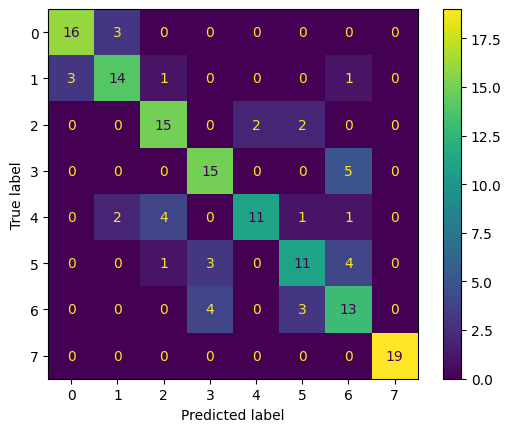

In [10]:
ConfusionMatrixDisplay.from_predictions(y_teste, predicao_rfc)
plt.show()

# Classificador Binário
---

In [11]:
df_ressonancias_bin = df_ressonancias.reset_index()

desgaste_bin = df_ressonancias.reset_index()['Desgaste'].map(lambda x: x > 2)
df_ressonancias_bin['Desgaste'] = desgaste_bin

df_ressonancias_bin.head()

,Desgaste,Amostra,0,1,2,3
0,False,R2_A2_0.15,-32.506695,-24.644065,29.952,81.744
1,False,R3_A2_0.75,-30.338431,-27.708322,29.744,81.744
2,False,R3_A2_0.15,-32.627895,-24.083694,29.952,81.744
3,False,R3_A2_0.4,-32.702030,-26.401221,29.744,81.536
4,False,R3_A2_0.2,-32.236878,-26.275198,29.744,81.744


In [12]:
data_bin = df_ressonancias_bin.drop(['Desgaste', 'Amostra'], axis=1)
labels_bin = df_ressonancias_bin['Desgaste']

x_treino_bin, x_teste_bin, y_treino_bin, y_teste_bin = train_test_split(data_bin, labels_bin, test_size=.2,
                                                                        stratify=labels_bin, random_state=RNG_SEED)

## Random Forest

In [13]:
modelo_rfc_bin = RandomForestClassifier(random_state=RNG_SEED)
metricas_bin = ["accuracy", "f1_macro", "precision_macro", "recall_macro"]
scores_bin = cross_validate(modelo_rfc_bin, x_treino_bin, y_treino_bin, scoring=metricas_bin)

mensagem = f"""Média Accuracy: {np.mean(scores_bin["test_accuracy"]):>8.2%}
DP Accuracy: {np.std(scores_bin["test_accuracy"]):>11.2}
{'':-^25}
Média F1: {np.mean(scores_bin["test_f1_macro"]):>14.2%}
Média Precision: {np.mean(scores_bin["test_precision_macro"]):>7.2%}
Média Recall: {np.mean(scores_bin["test_recall_macro"]):>10.2%}"""
print(mensagem)

Média Accuracy:   91.36%
DP Accuracy:       0.025
-------------------------
Média F1:         90.78%
Média Precision:  90.75%
Média Recall:     90.83%


In [14]:
modelo_rfc_bin.fit(x_treino_bin, y_treino_bin)
predicao_rfc_bin = modelo_rfc_bin.predict(x_teste_bin)

mensagem = f"""Accuracy: {accuracy_score(y_teste_bin, predicao_rfc_bin):>5.2%}
F1: {f1_score(y_teste_bin, predicao_rfc_bin, average='macro'):>12.2%}"""
print(mensagem)

Accuracy: 92.86%
F1:       92.31%


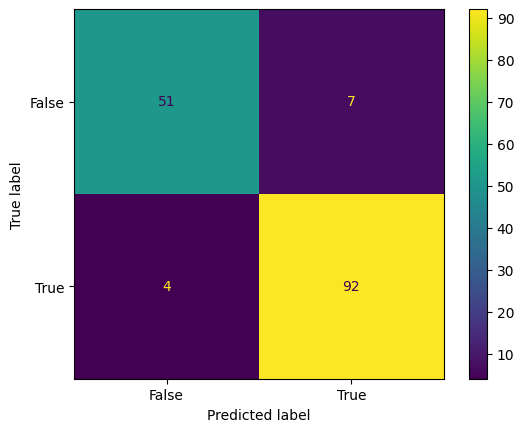

In [15]:
ConfusionMatrixDisplay.from_predictions(y_teste_bin, predicao_rfc_bin)
plt.show()

## Modelo Sequencial - Keras

In [16]:
modelo_mlp_bin = keras.Sequential([
    keras.layers.Input(np.shape(x_treino_bin.iloc[0, :])),
    keras.layers.Dense(64, keras.activations.relu),
    keras.layers.Dense(32, keras.activations.relu),
    keras.layers.Dense(1, keras.activations.sigmoid)
])
modelo_mlp_bin.compile(
    keras.optimizers.Adam(),
    keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()]
)
modelo_mlp_bin.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,433 (9.50 KB)

 Trainable params: 2,433 (9.50 KB)

 Non-trainable params: 0 (0.00 B)

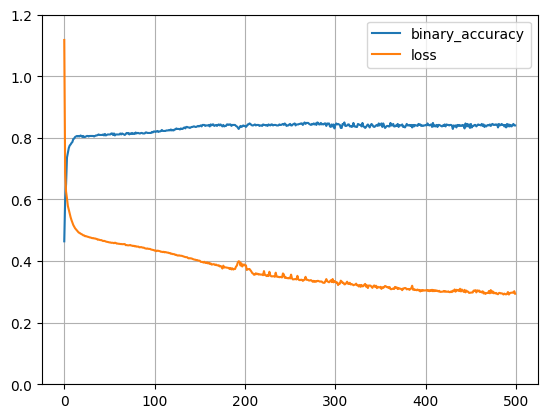

In [17]:
historico_bin = modelo_mlp_bin.fit(x_treino_bin, y_treino_bin, epochs=500, verbose=0)

pd.DataFrame(historico_bin.history).plot()
plt.grid(True)
plt.ylim(0, 1.2)
plt.show()

In [18]:
predicao_mlp_bin = modelo_mlp_bin.predict(x_teste_bin, verbose=0) > .75 # Limiar de 75% de confiança

mensagem = f"""Accuracy: {accuracy_score(y_teste_bin, predicao_mlp_bin):>5.2%}
F1: {f1_score(y_teste_bin, predicao_mlp_bin, average='macro'):>12.2%}"""
print(mensagem)

Accuracy: 87.66%
F1:       87.21%


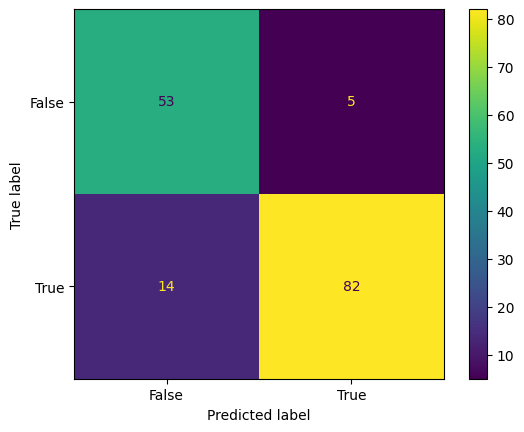

In [19]:
ConfusionMatrixDisplay.from_predictions(y_teste_bin, predicao_mlp_bin)
plt.show()